# Analysis of Financial Markets based on President Trump's Tweets

## Data Preprocessing

### Importing Data

In [1]:
!pip install -q kaggle

In [ ]:
# Upload kaggle.json file containing your API key
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle 

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Check to see if the API is working correctly 
# ! kaggle datasets list

In [ ]:
! kaggle datasets download -d austinreese/trump-tweets

In [ ]:
! pip install yfinance

### Data Cleaning

In [8]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
import spacy

#### Twitter Data

In [9]:
data = ZipFile("/content/trump-tweets.zip")
trump_tweets = pd.read_csv(data.open('trumptweets.csv'))
trump_tweets.head()

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN


In [10]:
trump_tweets.shape

(41122, 9)

The dataframe shows that there are 41,122 rows and 9 columns. Three of these columns mention, hashtags, and geo are currenly showing NaN for the first five rows. 

In [11]:
trump_tweets.describe()

,id,retweets,favorites,geo
count,4.112200e+04,41122.000000,41122.000000,0.0
mean,6.088909e+17,5455.590657,22356.899105,NaN
std,3.027946e+17,10130.076661,41501.859711,NaN
min,1.698309e+09,0.000000,0.000000,NaN
25%,3.549428e+17,25.000000,28.000000,NaN
50%,5.609149e+17,291.000000,247.000000,NaN
75%,7.941218e+17,8778.000000,32970.750000,NaN
max,1.219077e+18,309892.000000,857678.000000,NaN


In [12]:
#Remove NaN and non-important columns
trump_tweets = trump_tweets.drop(labels=['mentions', 'hashtags', 'geo', 'link'], axis='columns')
trump_tweets

,id,content,date,retweets,favorites
0,1698308935,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868
1,1701461182,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24
4,1773561338,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965
...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Stro...,2020-01-19 19:24:52,32620,213817
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wi...,2020-01-19 22:12:20,36239,149571
41119,1219053709428248576,I was thrilled to be back in the Great State o...,2020-01-20 01:27:07,16588,66944
41120,1219066007731310593,"“In the House, the President got less due proc...",2020-01-20 02:16:00,20599,81921


In [13]:
trump_tweets.dtypes

id            int64
content      object
date         object
retweets      int64
favorites     int64
dtype: object

In [14]:
# The date column is an object when it should be datetime
trump_tweets['date'] = pd.to_datetime(trump_tweets['date'], format='%Y%m%d %H:%M:%S')

In [15]:
# Split the date column into 2 seperate columns
trump_tweets['Time'],trump_tweets['Date']= trump_tweets['date'].apply(lambda x:x.time()), trump_tweets['date'].apply(lambda x:x.date())
trump_tweets = trump_tweets.drop(labels='date',axis='columns')

In [16]:
trump_tweets.head()

,id,content,retweets,favorites,Time,Date
0,1698308935,Be sure to tune in and watch Donald Trump on L...,500,868,20:54:25,2009-05-04
1,1701461182,Donald Trump will be appearing on The View tom...,33,273,03:00:10,2009-05-05
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,12,18,15:38:08,2009-05-08
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,11,24,22:40:15,2009-05-08
4,1773561338,"""My persona will never be that of a wallflower...",1399,1965,16:07:28,2009-05-12


In [17]:
trump_tweets['content']

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
41117    I have never seen the Republican Party as Stro...
41118    Now Mini Mike Bloomberg is critical of Jack Wi...
41119    I was thrilled to be back in the Great State o...
41120    “In the House, the President got less due proc...
41121    A great show! Check it out tonight at 9pm. @ F...
Name: content, Length: 41122, dtype: object

We want to clean the tweets through the removal of objects such as hashtags, links to external media, punctuation, and extra spaces that may be in the tweets. 

In [18]:
trump_tweets.content[30889]	

'LIVE on # Periscope: Join me for a few minutes in Pennsylvania. Get out & VOTE tomorrow. LETS # MAGA!!https://www.pscp.tv/w/au-0MDEyMzE3NDF8MXlvS01EQmFNYmx4UXtaU1dFdbs2hR83RLldPOOt9N_C3W-1tUxAlJep-jBY …'

In [19]:
# More Cleaning
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 #text = re.sub('https?://[A-Za-z0-9./]+', '', text) 
 text = re.sub(r"http\S+", '', text) # Removing hyperlink
 text = re.sub('pic.twitter.com/[A-Za-z0-9./]+', '', text) # Remove picture link
 text = re.sub(' +', ' ', text)
 return text

# Clean the tweets
trump_tweets['content'] = trump_tweets['content'].apply(cleanTxt)

# Remove punctuation from content column
trump_tweets['content'] = trump_tweets['content'].str.replace('[^\w\s]','')


In [20]:
trump_tweets.content[30889]	

'LIVE on Periscope Join me for a few minutes in Pennsylvania Get out  VOTE tomorrow LETS MAGA '

In [21]:
pd.set_option("max_colwidth", None)
trump_tweets.head()

,id,content,retweets,favorites,Time,Date
0,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight,500,868,20:54:25,2009-05-04
1,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion,33,273,03:00:10,2009-05-05
2,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman Very funny,12,18,15:38:08,2009-05-08
3,1741160716,New Blog Post Celebrity Apprentice Finale and Lessons Learned Along the Way,11,24,22:40:15,2009-05-08
4,1773561338,My persona will never be that of a wallflower Id rather build walls than cling to them Donald J Trump,1399,1965,16:07:28,2009-05-12


Slice out the rows that are not needed. 

In [22]:
tweets = trump_tweets[trump_tweets['Date'] >= pd.to_datetime('2016-11-08')]
tweets

,id,content,retweets,favorites,Time,Date
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08
...,...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Strong and as Unified as it is right now Thank you,32620,213817,19:24:52,2020-01-19
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wilson who saved perhaps hundreds of people in a Church because he was carrying a gun and knew how to use it Jack quickly killed the shooter who was beginning a rampage Mini is against the 2nd A His ads are Fake just like him,36239,149571,22:12:20,2020-01-19
41119,1219053709428248576,I was thrilled to be back in the Great State of Texas tonight where the people are known for being tough strong hardworking loyal and fiercely patriotic just like Americas incredible Farmers AFBF2020,16588,66944,01:27:07,2020-01-20
41120,1219066007731310593,In the House the President got less due process than the 911 terrorists got This is a corrupt process Mark Levin marklevinshow Very much so RepDougCollins FoxNews,20599,81921,02:16:00,2020-01-20


#### Stock Market Data

The Yahoo Finance API is utilized for market data from November 8th 2016 through present day.

In [23]:
import yfinance as yf
market_data = yf.download('NDAQ',start='2016-11-08', end='2020-01-20')
market_data.to_csv('market_data.csv')

[*********************100%***********************]  1 of 1 completed


In [24]:
stock_data = pd.read_csv('/content/market_data.csv')
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-08,65.440002,65.570000,64.190002,65.379997,60.392429,666500
1,2016-11-09,65.209999,67.139999,64.690002,66.930000,61.824188,1034000
2,2016-11-10,67.489998,68.290001,66.889999,67.099998,61.981224,1211200
3,2016-11-11,66.980003,67.320000,65.870003,66.440002,61.371571,889400
4,2016-11-14,66.620003,66.660004,64.570000,64.730003,59.792015,1413300


In [25]:
stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
798,2020-01-13,107.000000,107.529999,106.830002,107.089996,105.344879,394800
799,2020-01-14,107.260002,107.260002,106.330002,106.550003,104.813698,705200
800,2020-01-15,106.400002,108.209999,106.400002,107.860001,106.102348,623200
801,2020-01-16,108.559998,108.639999,107.779999,108.309998,106.545013,1085300
802,2020-01-17,108.459999,109.370003,108.029999,109.309998,107.528709,790800


In [26]:
stock_data.shape

(803, 7)

In [27]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [28]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,803.000000,803.000000,803.000000,803.000000,803.000000,8.030000e+02
mean,84.331968,84.973026,83.659589,84.344396,80.602755,8.490504e+05
std,11.677265,11.762641,11.554972,11.670628,12.492388,3.644722e+05
min,63.700001,64.320000,63.360001,63.549999,58.702042,2.179000e+05
25%,74.205002,74.744999,73.669998,74.334999,69.690365,5.935500e+05
50%,85.410004,86.190002,84.459999,85.290001,81.708557,7.687000e+05
75%,93.055000,93.605000,92.330002,93.060001,89.065872,1.018850e+06
max,108.559998,109.370003,108.029999,109.309998,107.528709,2.973800e+06


In [29]:
# Round columns with decimal places to only 2 decimal places
stock_data = stock_data.round(decimals=2)
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-08,65.44,65.57,64.19,65.38,60.39,666500
1,2016-11-09,65.21,67.14,64.69,66.93,61.82,1034000
2,2016-11-10,67.49,68.29,66.89,67.10,61.98,1211200
3,2016-11-11,66.98,67.32,65.87,66.44,61.37,889400
4,2016-11-14,66.62,66.66,64.57,64.73,59.79,1413300
...,...,...,...,...,...,...,...
798,2020-01-13,107.00,107.53,106.83,107.09,105.34,394800
799,2020-01-14,107.26,107.26,106.33,106.55,104.81,705200
800,2020-01-15,106.40,108.21,106.40,107.86,106.10,623200
801,2020-01-16,108.56,108.64,107.78,108.31,106.55,1085300


In [30]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       803 non-null    datetime64[ns]
 1   Open       803 non-null    float64       
 2   High       803 non-null    float64       
 3   Low        803 non-null    float64       
 4   Close      803 non-null    float64       
 5   Adj Close  803 non-null    float64       
 6   Volume     803 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 44.0 KB


There is not much cleaning that needs to take place for the stock market data. 

## Exploratory Analysis

In [31]:
import seaborn as sns 
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('fivethirtyeight')

### Null Values in Tweets

Now that the data is cleaned up, lets preform some exploritory anlaysis for the 2 data sets.

In [32]:
tweets.isnull().sum()

id           0
content      0
retweets     0
favorites    0
Time         0
Date         0
dtype: int64

In [33]:
stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no missing values for either of the data sets. 

### Dates of Tweets

In [34]:
tweets.head()

,id,content,retweets,favorites,Time,Date
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08


In [35]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
tweets['Date'].describe

<bound method NDFrame.describe of 30889   2016-11-08
30890   2016-11-08
30891   2016-11-08
30892   2016-11-08
30893   2016-11-08
           ...    
41117   2020-01-19
41118   2020-01-19
41119   2020-01-20
41120   2020-01-20
41121   2020-01-20
Name: Date, Length: 10233, dtype: datetime64[ns]>

In [37]:
tweets.head()

,id,content,retweets,favorites,Time,Date
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08


In [38]:
tweets['Day'] = tweets['Date'].dt.day
tweets['Month'] = tweets['Date'].dt.month
tweets['Year'] = tweets['Date'].dt.year
tweets['Month_Year'] =  tweets['Month'].map(str) + '-' + tweets['Year'].map(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [39]:
tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08,8,11,2016,11-2016
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08,8,11,2016,11-2016
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08,8,11,2016,11-2016
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08,8,11,2016,11-2016
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08,8,11,2016,11-2016


In [40]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10233 entries, 30889 to 41121
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          10233 non-null  int64         
 1   content     10233 non-null  object        
 2   retweets    10233 non-null  int64         
 3   favorites   10233 non-null  int64         
 4   Time        10233 non-null  object        
 5   Date        10233 non-null  datetime64[ns]
 6   Day         10233 non-null  int64         
 7   Month       10233 non-null  int64         
 8   Year        10233 non-null  int64         
 9   Month_Year  10233 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 879.4+ KB


<BarContainer object of 5 artists>

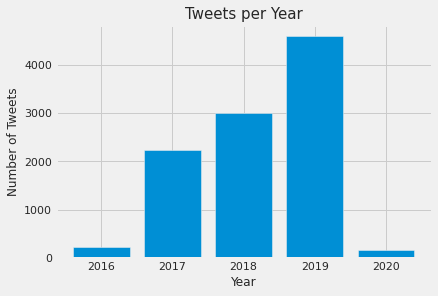

In [41]:
tweets_per_year = {}
for i in tweets['Year']:
  if i not in tweets_per_year:
    tweets_per_year[i] = 1
  else:
    tweets_per_year[i] += 1

keys = tweets_per_year.keys()
values = tweets_per_year.values()

plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.title("Tweets per Year", fontsize=15)
plt.bar(keys,values)

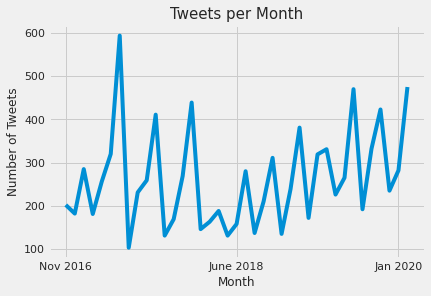

In [42]:
tweets_per_month = {}
for i in tweets['Month_Year']:
  if i not in tweets_per_month:
    tweets_per_month[i] = 1
  else:
    tweets_per_month[i] += 1

lists = sorted(tweets_per_month.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.title("Tweets per Month", fontsize=15)
plt.xticks([0, 19, 37], ['Nov 2016', 'June 2018', 'Jan 2020'])
plt.show()

### Content of Tweets

In [43]:
tweet = tweets['content']
tweet

30889                                                                                                                                                                                    LIVE on Periscope Join me for a few minutes in Pennsylvania Get out  VOTE tomorrow LETS MAGA 
30890                                                                                                                                                                  Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here  The big vote tomorrow
30891                                                                                                             Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont   bei WilkesBarreScranton International Airport AVP
30892                                                                                                                                                   Big news to

In [44]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
def most_used_words(text):
    tokens = word_tokenize(text)
    frequency_dist = nltk.FreqDist(tokens)
    print("There is %d different words" % len(set(tokens)))
    return sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
most_used_words(tweet.str.cat())[:5]

There is 24424 different words


['the', 'to', 'and', 'of', 'a']

### Plot Market Data 

In [46]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-08,65.44,65.57,64.19,65.38,60.39,666500
1,2016-11-09,65.21,67.14,64.69,66.93,61.82,1034000
2,2016-11-10,67.49,68.29,66.89,67.10,61.98,1211200
3,2016-11-11,66.98,67.32,65.87,66.44,61.37,889400
4,2016-11-14,66.62,66.66,64.57,64.73,59.79,1413300


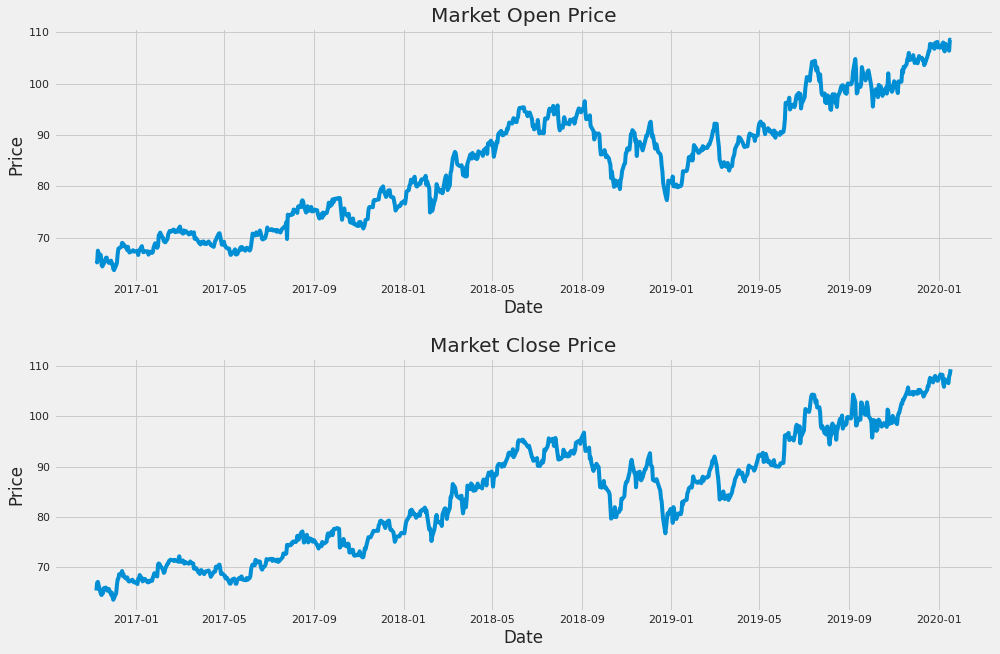

In [47]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(stock_data['Date'], stock_data['Open'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title('Market Open Price')
plt.subplots_adjust(hspace=0.3)
ax2.plot(stock_data['Date'], stock_data['Close'])
ax2.set_xlabel("Date")
ax2.set_ylabel("Price")
ax2.set_title('Market Close Price')
plt.show()

Calculate Moving Average

In [48]:
stock_data["SMA1"] = stock_data['Close'].rolling(window=50).mean()
stock_data["SMA2"] = stock_data['Close'].rolling(window=200).mean()

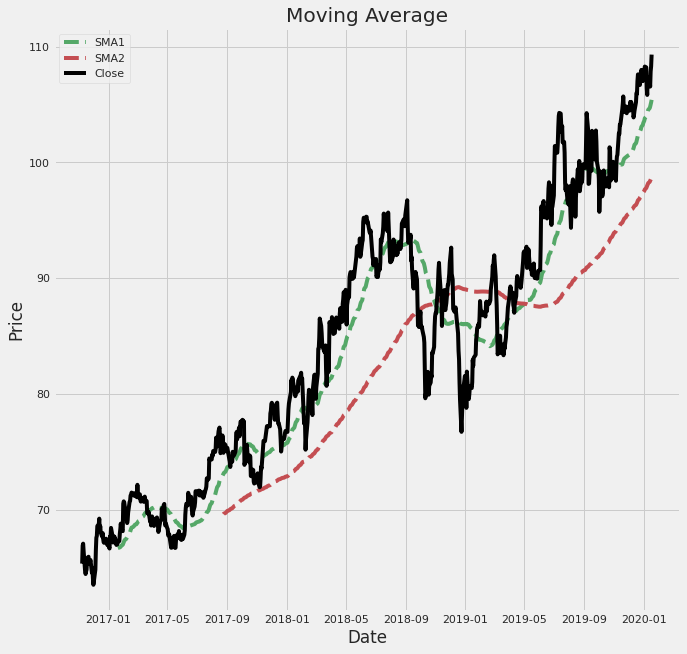

In [49]:
plt.figure(figsize=(10,10))
plt.plot(stock_data['Date'], stock_data['SMA1'], 'g--', label="SMA1")
plt.plot(stock_data['Date'], stock_data['SMA2'], 'r--', label="SMA2")
plt.plot(stock_data['Date'], stock_data['Close'], color='black', label="Close")
plt.title("Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot()
plt.legend()
plt.show()

In [50]:
stock_data = stock_data.drop(['SMA1', 'SMA2'], axis=1)

## Sentiment Analysis

In [51]:
from textblob import TextBlob
from wordcloud import WordCloud

In [52]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
tweets['Subjectivity'] = tweet.apply(getSubjectivity)
tweets['Polarity'] = tweet.apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
tweets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08,8,11,2016,11-2016,0.300000,-0.031818
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08,8,11,2016,11-2016,0.277273,0.068182
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08,8,11,2016,11-2016,0.000000,0.000000
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08,8,11,2016,11-2016,0.326136,0.234091
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08,8,11,2016,11-2016,0.818182,0.128788
...,...,...,...,...,...,...,...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Strong and as Unified as it is right now Thank you,32620,213817,19:24:52,2020-01-19,19,1,2020,1-2020,0.634524,0.359524
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wilson who saved perhaps hundreds of people in a Church because he was carrying a gun and knew how to use it Jack quickly killed the shooter who was beginning a rampage Mini is against the 2nd A His ads are Fake just like him,36239,149571,22:12:20,2020-01-19,19,1,2020,1-2020,0.450000,-0.175000
41119,1219053709428248576,I was thrilled to be back in the Great State of Texas tonight where the people are known for being tough strong hardworking loyal and fiercely patriotic just like Americas incredible Farmers AFBF2020,16588,66944,01:27:07,2020-01-20,20,1,2020,1-2020,0.678571,0.382540
41120,1219066007731310593,In the House the President got less due process than the 911 terrorists got This is a corrupt process Mark Levin marklevinshow Very much so RepDougCollins FoxNews,20599,81921,02:16:00,2020-01-20,20,1,2020,1-2020,0.425417,-0.132917


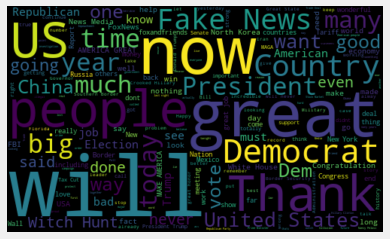

In [53]:
# word cloud visualization
allWords = ' '.join([twts for twts in tweet])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [54]:
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

tweets['Analysis'] = tweets['Polarity'].apply(getAnalysis)# Show the dataframe
tweets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08,8,11,2016,11-2016,0.300000,-0.031818,Negative
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08,8,11,2016,11-2016,0.277273,0.068182,Positive
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08,8,11,2016,11-2016,0.000000,0.000000,Neutral
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08,8,11,2016,11-2016,0.326136,0.234091,Positive
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08,8,11,2016,11-2016,0.818182,0.128788,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Strong and as Unified as it is right now Thank you,32620,213817,19:24:52,2020-01-19,19,1,2020,1-2020,0.634524,0.359524,Positive
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wilson who saved perhaps hundreds of people in a Church because he was carrying a gun and knew how to use it Jack quickly killed the shooter who was beginning a rampage Mini is against the 2nd A His ads are Fake just like him,36239,149571,22:12:20,2020-01-19,19,1,2020,1-2020,0.450000,-0.175000,Negative
41119,1219053709428248576,I was thrilled to be back in the Great State of Texas tonight where the people are known for being tough strong hardworking loyal and fiercely patriotic just like Americas incredible Farmers AFBF2020,16588,66944,01:27:07,2020-01-20,20,1,2020,1-2020,0.678571,0.382540,Positive
41120,1219066007731310593,In the House the President got less due process than the 911 terrorists got This is a corrupt process Mark Levin marklevinshow Very much so RepDougCollins FoxNews,20599,81921,02:16:00,2020-01-20,20,1,2020,1-2020,0.425417,-0.132917,Negative


In [55]:
# Print positive tweets
#print('Printing positive tweets:\n')
j=1
sortedDF = tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Positive'):
    #print(str(j) + ') '+sortedDF['content'][i])
    #print()
    j=j+1

In [56]:
#Print negative tweets
#print('Printing negative tweets:\n')
j=1
sortedDF = tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Negative'):
    #print(str(j) + ') '+sortedDF['content'][i])
    #print()
    j=j+1

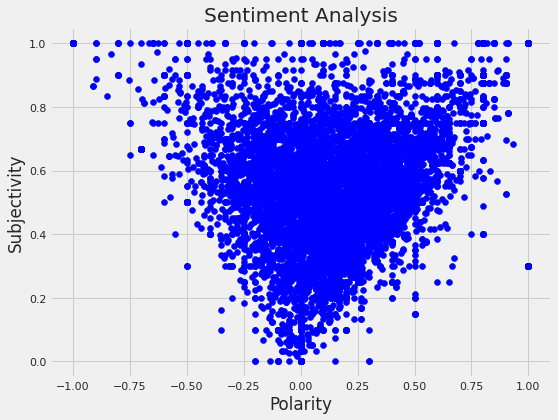

In [57]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(tweets["Polarity"][i], tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

### The Impeachment of President Trump

In [58]:
impeachment_tweets = tweets[tweets['Date'] >= pd.to_datetime('2019-11-01')]
impeachment_tweets = impeachment_tweets[impeachment_tweets['Date'] <= pd.to_datetime('2019-12-26')]
impeachment_tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
40091,1190067978089439239,The home of Nancy Pelosi I cant believe her voters can be happy with the job she and the Do Nothing Democrats are doing San Francisco has really gone down hill So sad,19889,71150,01:48:11,2019-11-01,1,11,2019,11-2019,0.622222,0.086111,Positive
40092,1190079191355670529,1600 Pennsylvania Avenue the White House is the place I have come to love and will stay for hopefully another 5 years as we MAKE AMERICA GREAT AGAIN but my family and I will be making Palm Beach Florida our Permanent Residence I cherish New York and the people of,23414,110209,02:32:44,2019-11-01,1,11,2019,11-2019,0.451136,0.359091,Positive
40093,1190079192358105088,New York and always will but unfortunately despite the fact that I pay millions of dollars in city state and local taxes each year I have been treated very badly by the political leaders of both the city and state Few have been treated worse I hated having to make,14888,75739,02:32:44,2019-11-01,1,11,2019,11-2019,0.477652,-0.346705,Negative
40094,1190079193582899200,this decision but in the end it will be best for all concerned As President I will always be there to help New York and the great people of New York It will always have a special place in my heart,15257,80248,02:32:45,2019-11-01,1,11,2019,11-2019,0.506104,0.485974,Positive
40095,1190085372815929344,Thank you,15105,64505,02:57:18,2019-11-01,1,11,2019,11-2019,0.000000,0.000000,Neutral


In [59]:
# print('Printing positive tweets:\n')
j=1
sortedDF = impeachment_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Positive'):
#     print(str(j) + ') '+sortedDF['content'][i])
#     print()
    j=j+1

In [60]:
# print('Printing negative tweets:\n')
j=1
sortedDF = impeachment_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Negative'):
#     print(str(j) + ') '+sortedDF['content'][i])
#     print()
    j=j+1

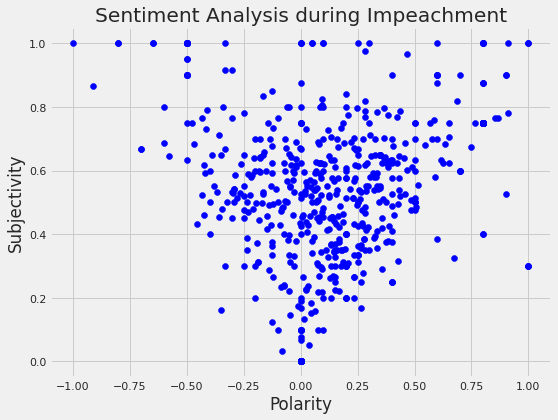

In [61]:
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(impeachment_tweets["Polarity"][i], impeachment_tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis during Impeachment') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [62]:
impeachment_tweets

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
40091,1190067978089439239,The home of Nancy Pelosi I cant believe her voters can be happy with the job she and the Do Nothing Democrats are doing San Francisco has really gone down hill So sad,19889,71150,01:48:11,2019-11-01,1,11,2019,11-2019,0.622222,0.086111,Positive
40092,1190079191355670529,1600 Pennsylvania Avenue the White House is the place I have come to love and will stay for hopefully another 5 years as we MAKE AMERICA GREAT AGAIN but my family and I will be making Palm Beach Florida our Permanent Residence I cherish New York and the people of,23414,110209,02:32:44,2019-11-01,1,11,2019,11-2019,0.451136,0.359091,Positive
40093,1190079192358105088,New York and always will but unfortunately despite the fact that I pay millions of dollars in city state and local taxes each year I have been treated very badly by the political leaders of both the city and state Few have been treated worse I hated having to make,14888,75739,02:32:44,2019-11-01,1,11,2019,11-2019,0.477652,-0.346705,Negative
40094,1190079193582899200,this decision but in the end it will be best for all concerned As President I will always be there to help New York and the great people of New York It will always have a special place in my heart,15257,80248,02:32:45,2019-11-01,1,11,2019,11-2019,0.506104,0.485974,Positive
40095,1190085372815929344,Thank you,15105,64505,02:57:18,2019-11-01,1,11,2019,11-2019,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40879,1210188790008037376,Nancy Pelosi has no leverage over the Senate Mitch McConnell did not nose his way into the impeachment process in the House and she has no standing in the Senate Brad Blakeman Crazy Nancy should clean up her filthy dirty District help the homeless there A primary for N,22872,93141,14:21:06,2019-12-26,26,12,2019,12-2019,0.780000,-0.246667,Negative
40880,1210207810291671045,Despite all of the great success that our Country has had over the last 3 years it makes it much more difficult to deal with foreign leaders and others when I am having to constantly defend myself against the Do Nothing Democrats their bogus Impeachment Scam Bad for USA,28363,124215,15:36:41,2019-12-26,26,12,2019,12-2019,0.430208,0.034375,Positive
40881,1210220021433208832,Russia Syria and Iran are killing or on their way to killing thousands of innocent civilians in Idlib Province Dont do it Turkey is working hard to stop this carnage,22822,107003,16:25:12,2019-12-26,26,12,2019,12-2019,0.620833,0.104167,Positive
40882,1210299694880088065,Trump stock market rally is far outpacing past US presidents,19438,82312,21:41:48,2019-12-26,26,12,2019,12-2019,0.625000,-0.075000,Negative


In [63]:
mean_subjectivity_impeach = impeachment_tweets.groupby("Date")['Subjectivity'].mean()
mean_polarity_impeach = impeachment_tweets.groupby("Date")['Polarity'].mean()

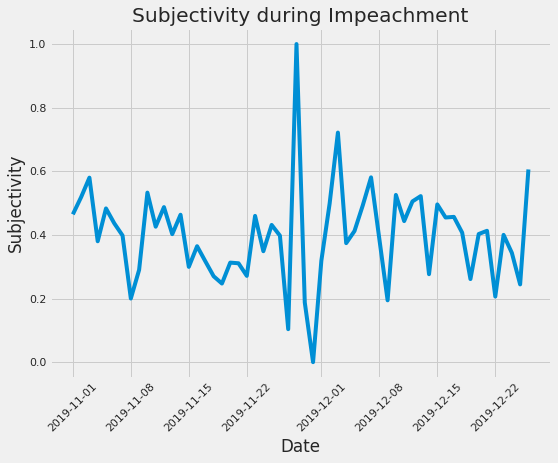

In [64]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_subjectivity_impeach) 
plt.title('Subjectivity during Impeachment') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Subjectivity') 
plt.show()

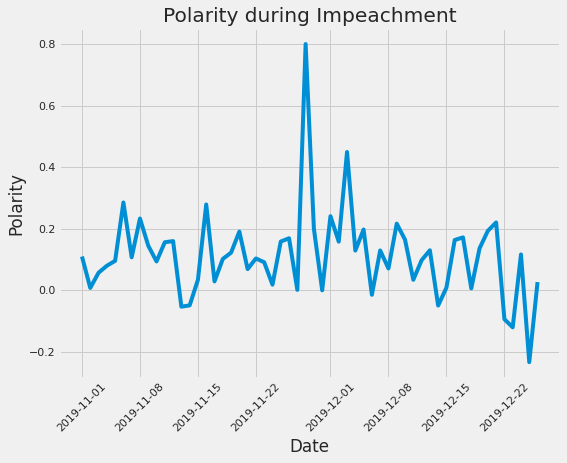

In [65]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_polarity_impeach) 
plt.title('Polarity during Impeachment') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Polarity') 
plt.show()

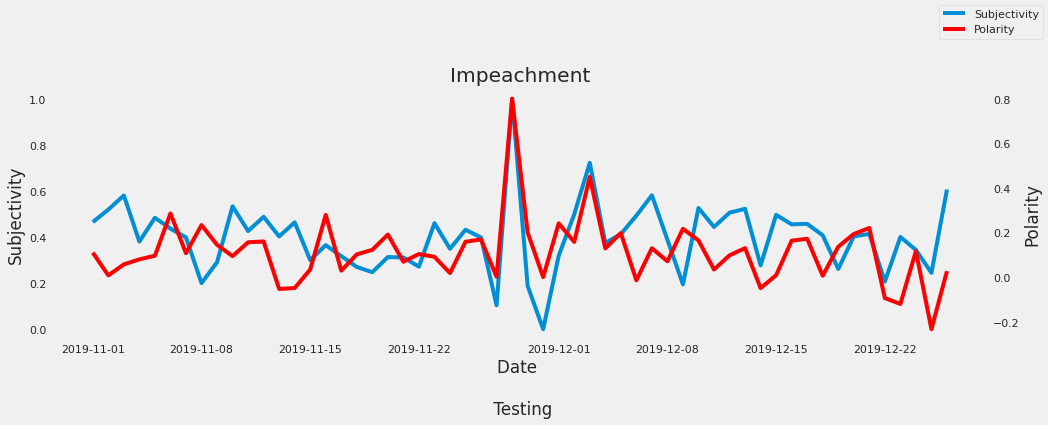

In [77]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(mean_subjectivity_impeach, label = "Subjectivity")
ax1.set_xlabel("Date \n \n Testing")
ax1.set_ylabel("Subjectivity")
ax1.set_title('Impeachment')
plt.subplots_adjust(hspace=0.3)
ax2 = ax1.twinx()

ax2.plot(mean_polarity_impeach, color = "red",label = "Polarity")
ax2.set_ylabel("Polarity")
fig.legend(labels=("Subjectivity", "Polarity"))
ax1.grid(False)
ax2.grid(False)
plt.show()

In [78]:
impeachment_stock_data = stock_data[stock_data['Date'] >= pd.to_datetime('2019-11-01')]
impeachment_stock_data = impeachment_stock_data[impeachment_stock_data['Date'] <= pd.to_datetime('2019-12-26')]
impeachment_stock_data["Daily Change"] = impeachment_stock_data['Close'] - impeachment_stock_data['Open']
impeachment_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change
750,2019-11-01,100.46,100.46,98.67,99.23,97.17,543600,-1.23
751,2019-11-04,99.73,99.78,98.53,98.59,96.54,553200,-1.14
752,2019-11-05,98.92,99.06,97.90,98.42,96.38,518300,-0.50
753,2019-11-06,98.16,100.08,97.98,99.92,97.85,678200,1.76
754,2019-11-07,100.44,100.67,99.16,100.53,98.44,959300,0.09


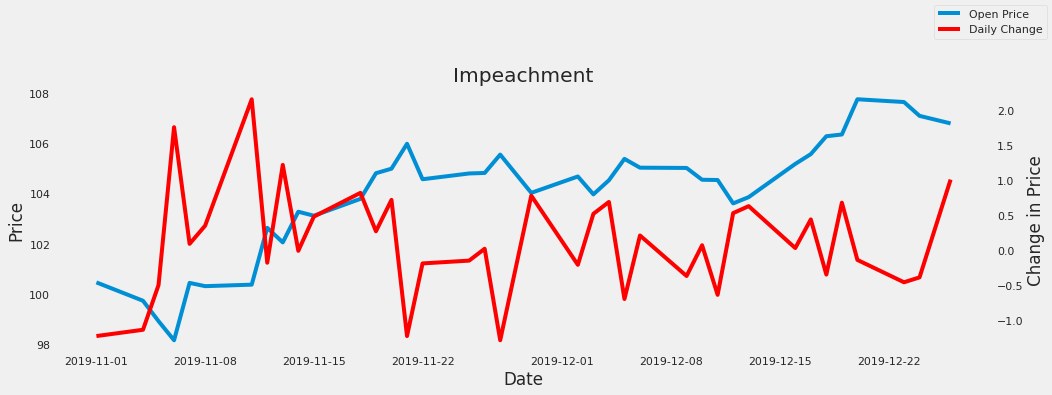

In [79]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(impeachment_stock_data['Date'], impeachment_stock_data['Open'], label = "Open Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Open Price")
ax1.set_title('Impeachment')
ax2 = ax1.twinx()

ax2.plot(impeachment_stock_data['Date'],  impeachment_stock_data['Daily Change'], color='red', label = "Daily Change")
ax2.set_xlabel("Date")
ax2.set_ylabel("Daily Change")
fig.legend(labels = ("Open Price", "Daily Change"))
ax1.grid(False)
ax2.grid(False)
plt.show()

### The Government Shutdown

In [80]:
shutdown_tweets = tweets[tweets['Date'] >= pd.to_datetime('2018-12-10')]
shutdown_tweets = shutdown_tweets[shutdown_tweets['Date'] <= pd.to_datetime('2019-02-26')]
shutdown_tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
36161,1071939400517500929,I am in the process of interviewing some really great people for the position of White House Chief of Staff Fake News has been saying with certainty it was Nick Ayers a spectacular person who will always be with our MAGA agenda I will be making a decision soon,15206,80607,02:27:23,2018-12-10,10,12,2018,12-2018,0.662500,0.225000,Positive
36162,1072095127894667265,Democrats cant find a Smocking Gun tying the Trump campaign to Russia after James Comeys testimony No Smocking GunNo Collusion FoxNews Thats because there was NO COLLUSION So now the Dems go to a simple private transaction wrongly call it a campaign contribution,22253,96987,12:46:11,2018-12-10,10,12,2018,12-2018,0.544048,-0.166667,Negative
36163,1072098604599394305,which it was not but even if it was it is only a CIVIL CASE like Obamas but it was done correctly by a lawyer and there would not even be a fine Lawyers liability if he made a mistake not me Cohen just trying to get his sentence reduced WITCH HUNT,20169,93307,13:00:00,2018-12-10,10,12,2018,12-2018,0.750000,0.208333,Positive
36164,1072312854307581953,James Comeys behind closed doors testimony reveals that there was not evidence of Campaign Collusion with Russia when he left the FBI In other words the Witch Hunt is illegal and should never have been started,23817,98892,03:11:21,2018-12-11,11,12,2018,12-2018,0.335000,-0.225000,Negative
36165,1072317149723717632,Former FBI Director James Comey under fire for his testimony acknowledging he knew that the Democrats paid for that phony Trump Dossier LouDobbs Details on Tuesday night,18389,74922,03:28:25,2018-12-11,11,12,2018,12-2018,0.000000,0.000000,Neutral


In [81]:
# print('Printing positive tweets:\n')
# j=1
sortedDF = shutdown_tweets.sort_values(by=['Polarity'], ascending=False) 
# for i in list(sortedDF.index):
#   if( sortedDF['Analysis'][i] == 'Positive'):
#     print(str(j) + ') '+sortedDF['content'][i])
#     print()
#     j=j+1

In [82]:
# print('Printing negative tweets:\n')
# j=1
sortedDF = shutdown_tweets.sort_values(by=['Polarity'], ascending=False) 
# for i in list(sortedDF.index):
#   if( sortedDF['Analysis'][i] == 'Negative'):
#     print(str(j) + ') '+sortedDF['content'][i])
#     print()
#     j=j+1

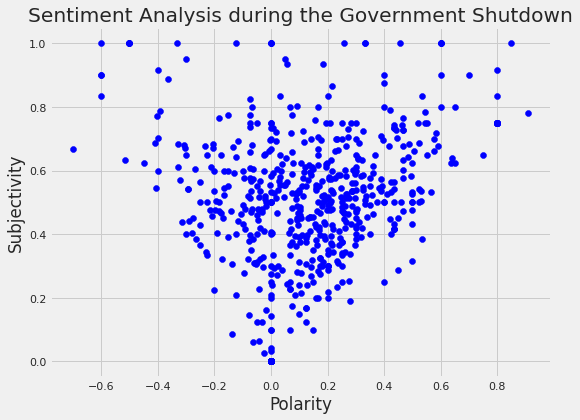

In [83]:
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(shutdown_tweets["Polarity"][i], shutdown_tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis during the Government Shutdown') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [91]:
mean_subjectivity_shutdown = shutdown_tweets.groupby("Date")['Subjectivity'].mean()
mean_polarity_shutdown = shutdown_tweets.groupby("Date")['Polarity'].mean()

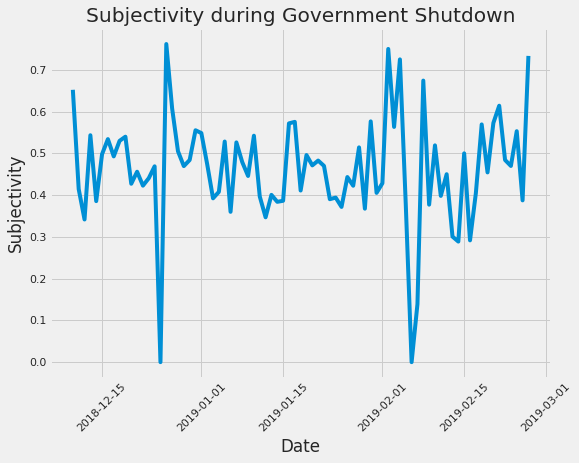

In [92]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_subjectivity_shutdown) 
plt.title('Subjectivity during Government Shutdown') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Subjectivity') 
plt.show()

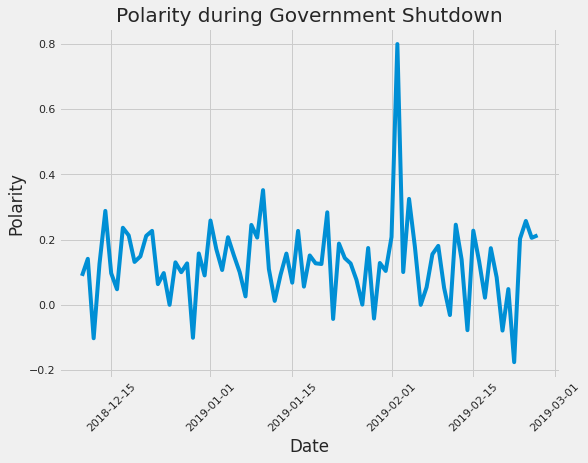

In [93]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_polarity_shutdown) 
plt.title('Polarity during Government Shutdown') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Polarity') 
plt.show()

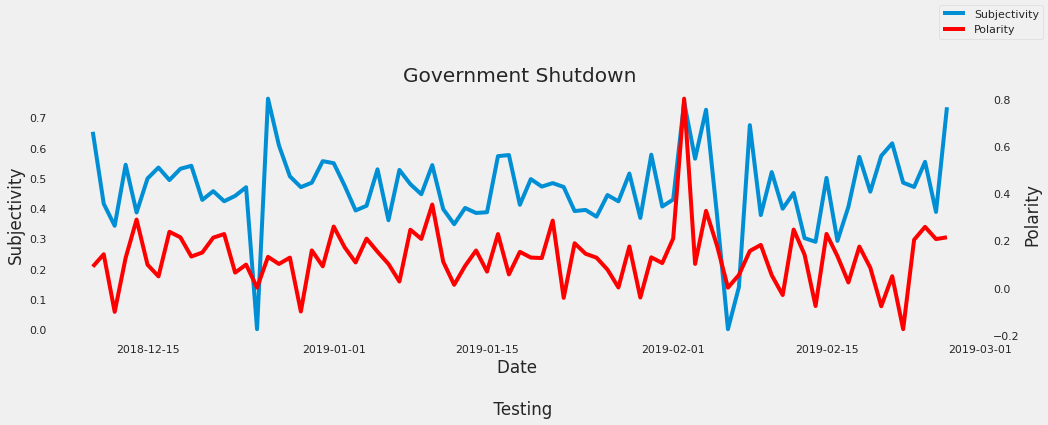

In [94]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(mean_subjectivity_shutdown, label = "Subjectivity")
ax1.set_xlabel("Date \n \n Testing")
ax1.set_ylabel("Subjectivity")
ax1.set_title('Government Shutdown')
plt.subplots_adjust(hspace=0.3)
ax2 = ax1.twinx()

ax2.plot(mean_polarity_shutdown, color = "red",label = "Polarity")
ax2.set_ylabel("Polarity")
fig.legend(labels=("Subjectivity", "Polarity"))
ax1.grid(False)
ax2.grid(False)
plt.show()

In [95]:
shutdown_stock_data = stock_data[stock_data['Date'] >= pd.to_datetime('2018-12-10')]
shutdown_stock_data = shutdown_stock_data[shutdown_stock_data['Date'] <= pd.to_datetime('2019-02-26')]
shutdown_stock_data["Daily Change"] = shutdown_stock_data['Close'] - shutdown_stock_data['Open']
shutdown_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change
524,2018-12-10,87.36,87.36,85.11,87.10,83.61,1033500,-0.26
525,2018-12-11,88.26,89.62,87.24,87.31,83.81,858200,-0.95
526,2018-12-12,88.16,88.72,87.41,87.49,83.98,560300,-0.67
527,2018-12-13,87.41,87.68,86.40,87.02,83.95,584900,-0.39
528,2018-12-14,86.72,87.34,86.01,86.54,83.49,535900,-0.18


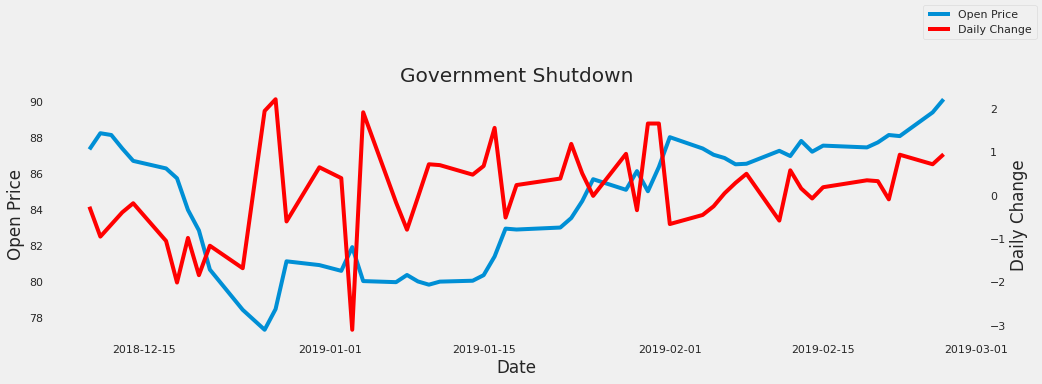

In [96]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(shutdown_stock_data['Date'], shutdown_stock_data['Open'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Open Price")
ax1.set_title('Government Shutdown')
plt.subplots_adjust(hspace=0.3)
ax2 = ax1.twinx()
ax2.plot(shutdown_stock_data['Date'], shutdown_stock_data['Daily Change'], color = "red")
ax2.set_xlabel("Date")
ax2.set_ylabel("Daily Change")
fig.legend(labels = ("Open Price", "Daily Change"))
ax1.grid(False)
ax2.grid(False)
plt.show()

### The Dakota Access and Keystone XL pipelines approval



In [97]:
dakota_tweets = tweets[tweets['Date'] >= pd.to_datetime('2017-01-14')]
dakota_tweets = dakota_tweets[dakota_tweets['Date'] <= pd.to_datetime('2017-02-14')]
dakota_tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
31214,820251730407473153,Congressman John Lewis should spend more time on fixing and helping his district which is in horrible shape and falling apart not to,17884,77341,13:50:26,2017-01-14,14,1,2017,1-2017,0.750000,-0.250000,Negative
31215,820255947956383744,mention crime infested rather than falsely complaining about the election results All talk talk talk no action or results Sad,13992,67390,14:07:12,2017-01-14,14,1,2017,1-2017,0.566667,-0.316667,Negative
31216,820257714362314753,INTELLIGENCE INSIDERS NOW CLAIM THE TRUMP DOSSIER IS A COMPLETE FRAUD OANN,16134,59755,14:14:13,2017-01-14,14,1,2017,1-2017,0.400000,0.100000,Positive
31217,820425770925338624,Congressman John Lewis should finally focus on the burning and crime infested innercities of the US I can use all the help I can get,18773,83963,01:22:01,2017-01-15,15,1,2017,1-2017,1.000000,0.000000,Neutral
31218,820450166331346944,Inauguration Day is turning out to be even bigger than expected January 20th Washington DC Have fun,21309,107301,02:58:57,2017-01-15,15,1,2017,1-2017,0.275000,0.050000,Positive


In [99]:
# print('Printing positive tweets:\n')
# j=1
sortedDF = dakota_tweets.sort_values(by=['Polarity'], ascending=False) 
# for i in list(sortedDF.index):
#   if( sortedDF['Analysis'][i] == 'Positive'):
#     print(str(j) + ') '+sortedDF['content'][i])
#     print()
#     j=j+1

In [100]:
# print('Printing negative tweets:\n')
# j=1
sortedDF = dakota_tweets.sort_values(by=['Polarity'], ascending=False) 
# for i in list(sortedDF.index):
#   if( sortedDF['Analysis'][i] == 'Negative'):
#     print(str(j) + ') '+sortedDF['content'][i])
#     print()
#     j=j+1

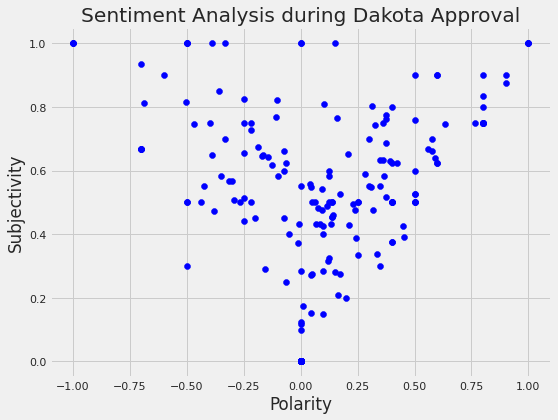

In [101]:
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(dakota_tweets["Polarity"][i], dakota_tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis during Dakota Approval') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [104]:
mean_subjectivity_pipeline = dakota_tweets.groupby("Date")['Subjectivity'].mean()
mean_polarity_pipeline = dakota_tweets.groupby("Date")['Polarity'].mean()

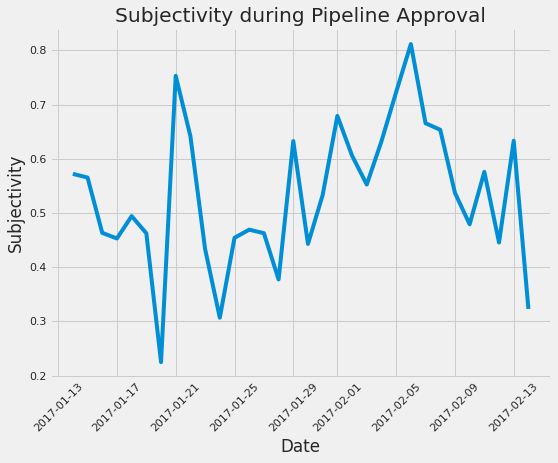

In [105]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_subjectivity_pipeline) 
plt.title('Subjectivity during Pipeline Approval') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Subjectivity') 
plt.show()

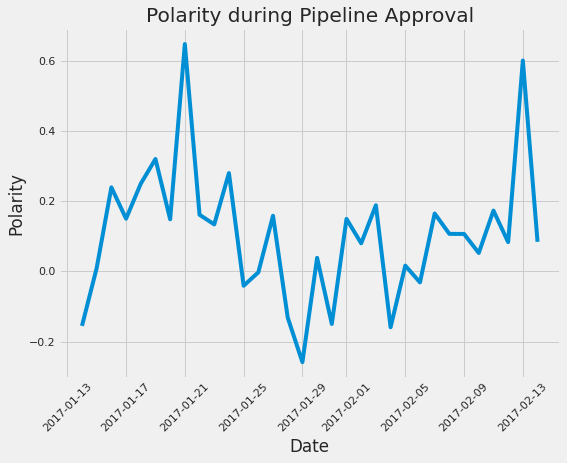

In [106]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_polarity_pipeline) 
plt.title('Polarity during Pipeline Approval') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Polarity') 
plt.show()

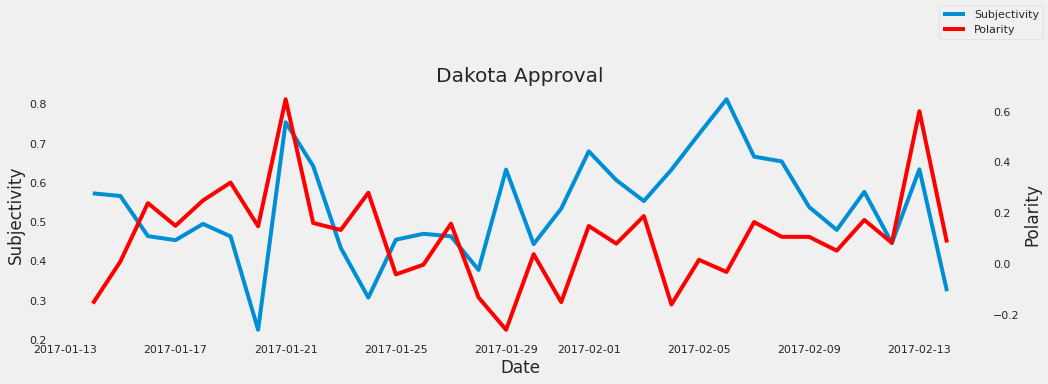

In [107]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(mean_subjectivity_pipeline)
ax1.set_xlabel("Date")
ax1.set_ylabel("Subjectivity")
ax1.set_title('Dakota Approval')
plt.subplots_adjust(hspace=0.3)
ax2 = ax1.twinx()

ax2.plot(mean_polarity_pipeline, color = "red")
ax2.set_ylabel("Polarity")
fig.legend(labels = ("Subjectivity", "Polarity"))
ax1.grid(False)
ax2.grid(False)
plt.show()

In [108]:
dakota_stock_data = stock_data[stock_data['Date'] >= pd.to_datetime('2017-01-14')]
dakota_stock_data = dakota_stock_data[dakota_stock_data['Date'] <= pd.to_datetime('2017-02-17')]
dakota_stock_data["Daily Change"] = dakota_stock_data['Close'] - dakota_stock_data['Open']
dakota_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change
46,2017-01-17,67.36,67.68,66.89,66.99,62.17,908800,-0.37
47,2017-01-18,66.71,67.29,66.62,67.25,62.41,777600,0.54
48,2017-01-19,67.06,67.34,66.49,67.06,62.23,625000,0.00
49,2017-01-20,67.30,67.58,66.84,67.36,62.51,637800,0.06
50,2017-01-23,67.06,67.68,66.67,67.32,62.47,629700,0.26


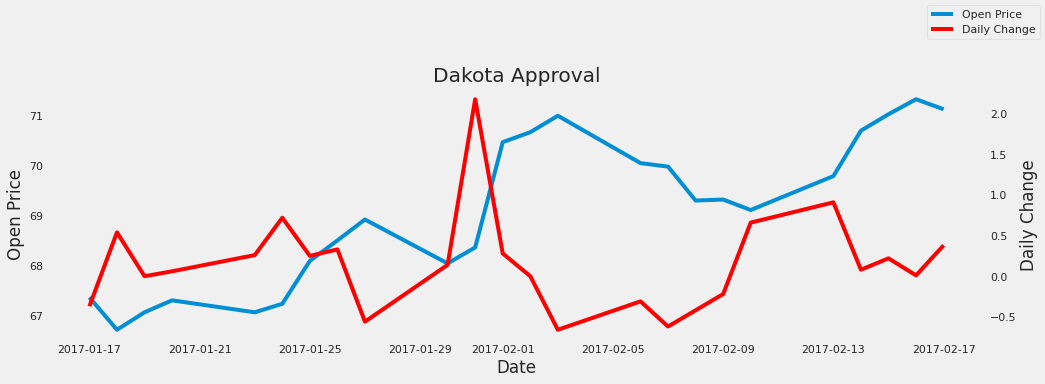

In [109]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(dakota_stock_data['Date'], dakota_stock_data['Open'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Open Price")
ax1.set_title('Dakota Approval')
plt.subplots_adjust(hspace=0.3)

ax2 = ax1.twinx()
ax2.plot(dakota_stock_data['Date'], dakota_stock_data['Daily Change'], color = "red")
ax2.set_ylabel("Daily Change")
fig.legend(labels = ("Open Price", "Daily Change"))
ax1.grid(False)
ax2.grid(False)
plt.show()